### DeepONet with CNN for branch and MLP for trunk (trunk has t and Δt as inputs)

## Best results till now (test 1 to 6):

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
import numpy as np
import torch
import xarray as xr

# Load NetCDF dataset
ds = xr.open_dataset('../dat/RBC_Output.nc')  # Adjust path if needed

# ===== 1. Grid selection =====
z_full = ds['z_aac'].values
x_full = ds['x_caa'].values

# Take top 50 z points and evenly 128 x points
z_sel_idx = np.linspace(0, len(z_full)-1, 50, dtype=int)
x_sel_idx = np.linspace(0, len(x_full)-1, 128, dtype=int)

z_vals = z_full[z_sel_idx]
x_vals = x_full[x_sel_idx]

# ===== 2. Fast slicing with eager loading =====
def slice_field(field, z_dim, x_dim):
    return np.array(field.isel({z_dim: z_sel_idx, x_dim: x_sel_idx}).values, dtype=np.float32)

# Limit time steps for prototyping (change this later)
max_time_steps = 50

b = slice_field(ds['b'].isel(time=slice(0, max_time_steps)), 'z_aac', 'x_caa')        # (time, z, x)
u = slice_field(ds['u'].isel(time=slice(0, max_time_steps)), 'z_aac', 'x_faa')        # (time, z, x)
w = slice_field(ds['w'].isel(time=slice(0, max_time_steps)), 'z_aaf', 'x_caa')        # (time, z, x)
p_dyn = slice_field(ds['p_dyn'].isel(time=slice(0, max_time_steps)), 'z_aac', 'x_caa') # (time, z, x)

time = np.array(ds['time'].isel(time=slice(0, max_time_steps)).values, dtype=np.float32)

print("✅ Shapes → b:", b.shape, "u:", u.shape, "w:", w.shape, "p_dyn:", p_dyn.shape)

# ===== 3. Compute Δb =====
delta_b = b[1:] - b[:-1]       # (time-1, z, x)
time_d = time[1:]              # matching time dimension

# ===== 4. Stack inputs (fast) =====
inputs = np.stack([u[:-1], w[:-1], p_dyn[:-1]], axis=1).astype(np.float32)  # (time-1, 3, z, x)
targets = delta_b.astype(np.float32)                                        # (time-1, z, x)
time_stamps = time_d.astype(np.float32)                                     # (time-1, )

print("✅ Inputs shape:", inputs.shape, "Targets shape:", targets.shape, "Times:", time_stamps.shape)

# ===== 5. Quick normalization (subset for stats) =====
subset = min(10, inputs.shape[0])  # small subset for fast mean/std estimation
inputs_mean = inputs[:subset].mean()
inputs_std = inputs[:subset].std()
inputs_norm = (inputs - inputs_mean) / (inputs_std + 1e-8)

targets_mean = targets[:subset].mean()
targets_std = targets[:subset].std()
targets_norm = (targets - targets_mean) / (targets_std + 1e-8)

time_min, time_max = time_stamps.min(), time_stamps.max()
time_norm = (time_stamps - time_min) / (time_max - time_min)

print("✅ Normalization done.")

# ===== 6. Convert to tensors =====
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_tensor = torch.tensor(inputs_norm, dtype=torch.float32).to(device)         # (N, 3, 50, 128)
Y_tensor = torch.tensor(targets_norm, dtype=torch.float32).to(device)        # (N, 50, 128)
t_tensor = torch.tensor(time_norm, dtype=torch.float32).unsqueeze(1).to(device)  # (N, 1)

print("✅ Final tensors:", X_tensor.shape, Y_tensor.shape, t_tensor.shape)


C:\Users\deban\AppData\Local\Temp\ipykernel_15380\2708789290.py:6: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset('../dat/RBC_Output.nc')  # Adjust path if needed


✅ Shapes → b: (50, 50, 128) u: (50, 50, 128) w: (50, 50, 128) p_dyn: (50, 50, 128)
✅ Inputs shape: (49, 3, 50, 128) Targets shape: (49, 50, 128) Times: (49,)
✅ Normalization done.
✅ Final tensors: torch.Size([49, 3, 50, 128]) torch.Size([49, 50, 128]) torch.Size([49, 1])


In [ ]:
# class BranchCNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.cnn = nn.Sequential(
#             nn.Conv2d(3, 16, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(16, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(64, 1, kernel_size=1)  # Output shape: (B, 1, 50, 128)
#         )
#     def forward(self, x):
#         return self.cnn(x).squeeze(1)  # → (B, 50, 128)

# class TrunkMLP(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.mlp = nn.Sequential(
#             nn.Linear(1, 32),
#             nn.ReLU(),
#             nn.Linear(32, 64*50*128),  # match spatial flattened
#             nn.ReLU()
#         )
#     def forward(self, t):
#         out = self.mlp(t)  # (B, feat)
#         return out.view(-1, 50, 128)  # reshape to (B, 50, 128)

# class DeepONetCNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.branch = BranchCNN()
#         self.trunk = TrunkMLP()
#     def forward(self, x, t):
#         B_out = self.branch(x)  # (B, 50, 128)
#         T_out = self.trunk(t)   # (B, 50, 128)
#         return B_out * T_out    # Elementwise → (B, 50, 128)


In [4]:
class DeepONetCNN(nn.Module):
    def __init__(self):
        super(DeepONetCNN, self).__init__()
        
        # Branch: CNN over (3, 50, 128)
        self.branch = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),  # Output: (B, 1, 50, 128)
            nn.Flatten(start_dim=1)  # (B, 50*128)
        )
        
        # Trunk: Time embedding → output 50*128 units
        self.trunk = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 50 * 128),  # must match spatial dim flattened
        )
        
    def forward(self, x, t):
        B_out = self.branch(x)  # (B, 50*128)
        T_out = self.trunk(t)    # (B, 50*128)
        
        # Multiply element-wise
        out = B_out * T_out      # (B, 50*128)
        out = out.view(-1, 50, 128)  # Reshape back to (B, 50, 128)
        return out


In [5]:
def compute_physics_loss(model, inputs, times, dz=1.0, dx=1.0, κ=1e-6):
    pred_delta_b = model(inputs, times)  # (B, z, x)
    
    u = inputs[:, 0]  # (B, z, x)
    w = inputs[:, 1]  # (B, z, x)

    # Compute derivatives
    b_x = (pred_delta_b[:, :, 2:] - pred_delta_b[:, :, :-2]) / (2 * dx)  # (B, z, x-2)
    b_z = (pred_delta_b[:, 2:, :] - pred_delta_b[:, :-2, :]) / (2 * dz)  # (B, z-2, x)

    u_c = u[:, :, 1:-1]           # (B, z, x-2) → matches b_x
    w_c = w[:, 1:-1, :]           # (B, z-2, x) → matches b_z

    # For safety, crop both to (B, z_crop, x_crop)
    min_z = min(b_z.shape[1], w_c.shape[1])
    min_x = min(b_x.shape[2], u_c.shape[2])

    b_x = b_x[:, :min_z, :min_x]
    b_z = b_z[:, :min_z, :min_x]
    u_c = u_c[:, :min_z, :min_x]
    w_c = w_c[:, :min_z, :min_x]

    advection = u_c * b_x + w_c * b_z

    b_xx = (pred_delta_b[:, :, 2:] - 2 * pred_delta_b[:, :, 1:-1] + pred_delta_b[:, :, :-2]) / (dx**2)
    b_zz = (pred_delta_b[:, 2:, :] - 2 * pred_delta_b[:, 1:-1, :] + pred_delta_b[:, :-2, :]) / (dz**2)

    b_xx = b_xx[:, :min_z, :min_x]
    b_zz = b_zz[:, :min_z, :min_x]

    diffusion = κ * (b_xx + b_zz)

    residual = advection - diffusion
    phy_loss = torch.mean(residual ** 2)
    
    return phy_loss


In [6]:
# Let's say:
# - Use first 30 time steps for training → train: indices 0 to 29
# - Next 10 for testing → test: indices 30 to 39

train_idx = np.arange(0, 30)   # First 30 (can adjust)
test_idx = np.arange(30, 40)   # Next 10

# Prepare splits
X_train_tensor = X_tensor[train_idx]           # (30, 3, 50, 128)
t_train_tensor = t_tensor[train_idx]           # (30, 1)
Y_train_tensor = Y_tensor[train_idx]           # (30, 50, 128)

X_test_tensor = X_tensor[test_idx]             # (10, 3, 50, 128)
t_test_tensor = t_tensor[test_idx]             # (10, 1)
Y_test_tensor = Y_tensor[test_idx]             # (10, 50, 128)

# Also for unnormalized time stamps for plotting:
time_train_np = time_d[train_idx]
time_test_np = time_d[test_idx]


In [7]:
# Define model, optimizer, loss
model = DeepONetCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
mse = nn.MSELoss()

num_epochs = 5000

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass on training set
    pred_train = model(X_train_tensor, t_train_tensor)                     # (30, 50, 128)
    
    # Observation loss: MSE on Δb
    obs_loss = mse(pred_train, Y_train_tensor)
    
    # Physics loss on same batch (or you can sample separately if needed)
    phy_loss = compute_physics_loss(model, X_train_tensor, t_train_tensor)
    
    # (Optional) Initial Condition Loss if available — currently not used
    ic_loss = torch.tensor(0.0, device=device)
    
    # Total loss: observation + physics (scale as needed)
    total_loss = obs_loss + 0.1 * phy_loss + ic_loss
    
    # Backward and step
    total_loss.backward()
    optimizer.step()
    
    # Print every 500 epochs
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Total Loss = {total_loss.item():.6f} | Obs = {obs_loss.item():.6f} | Phy = {phy_loss.item():.6f}")




Epoch 0: Total Loss = 0.618639 | Obs = 0.618603 | Phy = 0.000366
Epoch 500: Total Loss = 0.168272 | Obs = 0.157699 | Phy = 0.105738
Epoch 1000: Total Loss = 0.113181 | Obs = 0.101550 | Phy = 0.116313
Epoch 1500: Total Loss = 0.097997 | Obs = 0.086021 | Phy = 0.119757
Epoch 2000: Total Loss = 0.090929 | Obs = 0.078832 | Phy = 0.120972
Epoch 2500: Total Loss = 0.083469 | Obs = 0.071165 | Phy = 0.123038
Epoch 3000: Total Loss = 0.079126 | Obs = 0.066777 | Phy = 0.123492
Epoch 3500: Total Loss = 0.080348 | Obs = 0.067850 | Phy = 0.124982
Epoch 4000: Total Loss = 0.067974 | Obs = 0.055388 | Phy = 0.125861
Epoch 4500: Total Loss = 0.064659 | Obs = 0.051943 | Phy = 0.127162


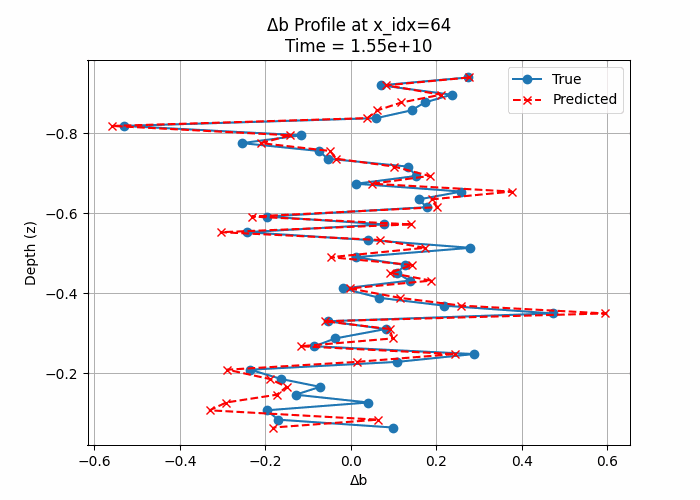

In [8]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image, display, HTML
import ipywidgets as widgets

# ----------------------------
# Evaluate on Test Set Only
# ----------------------------
model.eval()
with torch.no_grad():
    pred_test = model(X_test_tensor, t_test_tensor).cpu().numpy()        # (10, 50, 128)
    true_test = Y_test_tensor.cpu().numpy()                              # (10, 50, 128)

x_idx = 64  # fixed x index for profile (center)
trim_start = 3
trim_end = -3

z_trimmed = z_vals[trim_start:trim_end]
time_trimmed = time_test_np  # Already matches test data length

b_true_list = []
b_pred_list = []

for i in range(true_test.shape[0]):  # Loop over test frames (10)
    b_true_i = true_test[i, trim_start:trim_end, x_idx]
    b_pred_i = pred_test[i, trim_start:trim_end, x_idx]
    b_true_list.append(b_true_i)
    b_pred_list.append(b_pred_i)

# ----------------------------
# Overlayed Animation
# ----------------------------

fig, ax = plt.subplots(figsize=(7, 5))

def update(frame):
    ax.clear()
    ax.plot(b_true_list[frame], z_trimmed, label='True', marker='o')
    ax.plot(b_pred_list[frame], z_trimmed, label='Predicted', linestyle='--', marker='x', color='red')
    ax.set_title(f'Δb Profile at x_idx={x_idx}\nTime = {time_trimmed[frame]:.2e}')
    ax.set_xlabel('Δb')
    ax.set_ylabel('Depth (z)')
    ax.invert_yaxis()
    ax.legend()
    ax.grid(True)

ani = animation.FuncAnimation(fig, update, frames=len(b_true_list), blit=False, interval=1000)

# Save GIF for static display
ani.save('PINN_deltab_overlay.gif', writer='pillow', fps=0.5)
display(Image(filename='PINN_deltab_overlay.gif'))

# Interactive controls (play/pause bar)
plt.close(fig)  # Prevent duplicate static plot
html_anim = HTML(ani.to_jshtml())
display(html_anim)


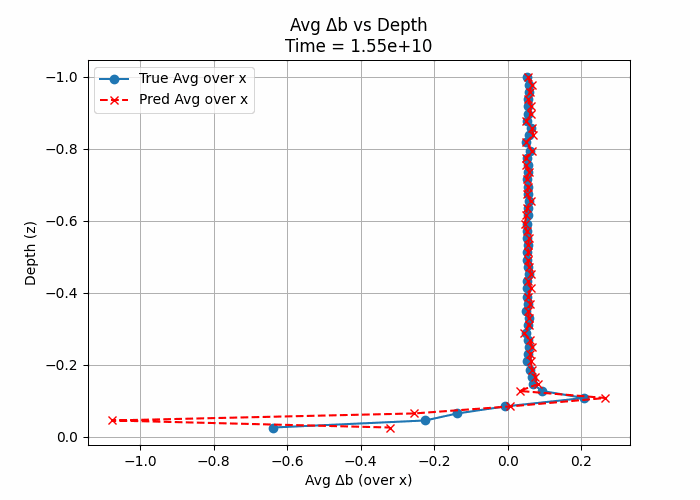

In [9]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image, display, HTML

# ----------------------------
# Evaluate on Test Set Only
# ----------------------------
model.eval()
with torch.no_grad():
    pred_test = model(X_test_tensor, t_test_tensor).cpu().numpy()        # (10, 50, 128)
    true_test = Y_test_tensor.cpu().numpy()                              # (10, 50, 128)                      # (N_test, 50, 128)

trim_start = 0
trim_end = -1

z_trimmed = z_vals[trim_start:trim_end]  # Depth range after trimming
time_trimmed = time_test_np              # Matches N_test

b_true_list = []
b_pred_list = []

for i in range(true_test.shape[0]):  # Loop over time frames
    # Average over x at each depth → shape: (50,)
    b_true_avg = true_test[i, :, :].mean(axis=1)[trim_start:trim_end]  # (trimmed_z,)
    b_pred_avg = pred_test[i, :, :].mean(axis=1)[trim_start:trim_end]  # (trimmed_z,)
    
    b_true_list.append(b_true_avg)
    b_pred_list.append(b_pred_avg)

# ----------------------------
# Overlayed Animation
# ----------------------------

fig, ax = plt.subplots(figsize=(7, 5))

def update(frame):
    ax.clear()
    ax.plot(b_true_list[frame], z_trimmed, label='True Avg over x', marker='o')
    ax.plot(b_pred_list[frame], z_trimmed, label='Pred Avg over x', linestyle='--', marker='x', color='red')
    ax.set_title(f'Avg Δb vs Depth\nTime = {time_trimmed[frame]:.2e}')
    ax.set_xlabel('Avg Δb (over x)')
    ax.set_ylabel('Depth (z)')
    ax.invert_yaxis()
    ax.legend()
    ax.grid(True)

ani = animation.FuncAnimation(fig, update, frames=len(b_true_list), blit=False, interval=1000)

ani.save('PINN_deltab_avg_overlay.gif', writer='pillow', fps=0.5)
display(Image(filename='PINN_deltab_avg_overlay.gif'))

plt.close(fig)
display(HTML(ani.to_jshtml()))
